# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import time
import logging
import logging.config

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/apple/"))  # To find local version
import apple

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_apple.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
# IMAGE_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "logs_test_img")
# IMAGE_DIR = os.path.join(ROOT_DIR, "images/AusTestPic")


# # create logger
# logging.config.fileConfig(os.path.join(ROOT_DIR, 'logging/logging.conf'))
# logger = logging.getLogger('shlxLog')

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [3]:
class InferenceConfig(apple.AppleConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.90

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

W0519 07:42:56.915518 139937507956480 deprecation.py:506] From /tf/mrcnn/model.py:423: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead
W0519 07:42:57.221643 139937507956480 deprecation.py:323] From /tf/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'apple']

## Run Object Detection

1558252311.9244618
points: 122
points: 136
no oddPoints
points: 117
points: 191
points: 143
points: 147
points: 134
points: 149
points: 95
points: 157
points: 141
points: 136
points: 140
points: 120
points: 147
points: 117
points: 138
points: 116
points: 144
points: 133
points: 141
points: 113
points: 94
points: 138
points: 132
points: 77
points: 57
points: 106
points: 73
points: 132
points: 45
points: 79
points: 71
points: 47
points: 91
points: 106
points: 87
points: 59
points: 61
points: 31
points: 85
points: 38
points: 40
points: 58
points: 72
points: 86
points: 35
points: 60
points: 70
points: 43
points: 53
points: 46
points: 82
points: 53
points: 68
points: 66
points: 64
points: 67
points: 39
points: 62
points: 66
points: 109


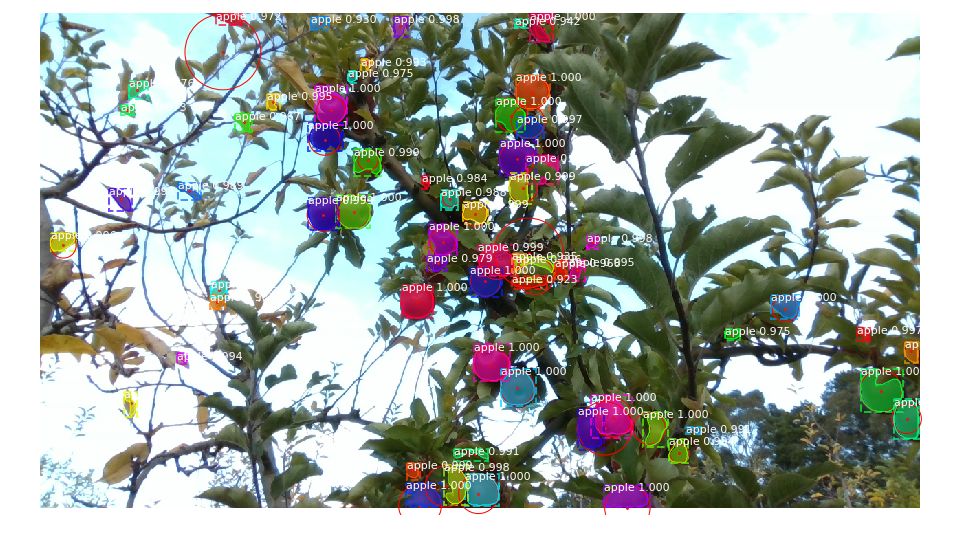

In [13]:
# Load a random image from the images folder
#file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

image = skimage.io.imread(os.path.join(IMAGE_DIR, "color_20190518T071146-Copy1.png"))
# Run detection
logging.debug('start detect')
results = model.detect([image], verbose=0)
logging.debug('end detect')

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

1558252327.693675
points: 123
points: 192
points: 136
points: 139
no oddPoints
points: 138
points: 135
points: 143
points: 119
points: 145
points: 134
points: 94
no oddPoints
points: 123
points: 118
points: 161
points: 145
points: 122
points: 116
points: 135
points: 85
points: 129
points: 109
points: 143
points: 140
points: 130
points: 106
points: 100
points: 130
points: 93
points: 140
points: 44
points: 52
points: 49
points: 53
points: 56
points: 72
points: 85
points: 93
points: 69
points: 51
points: 85
points: 88
points: 87
points: 35
points: 61
points: 46
points: 117


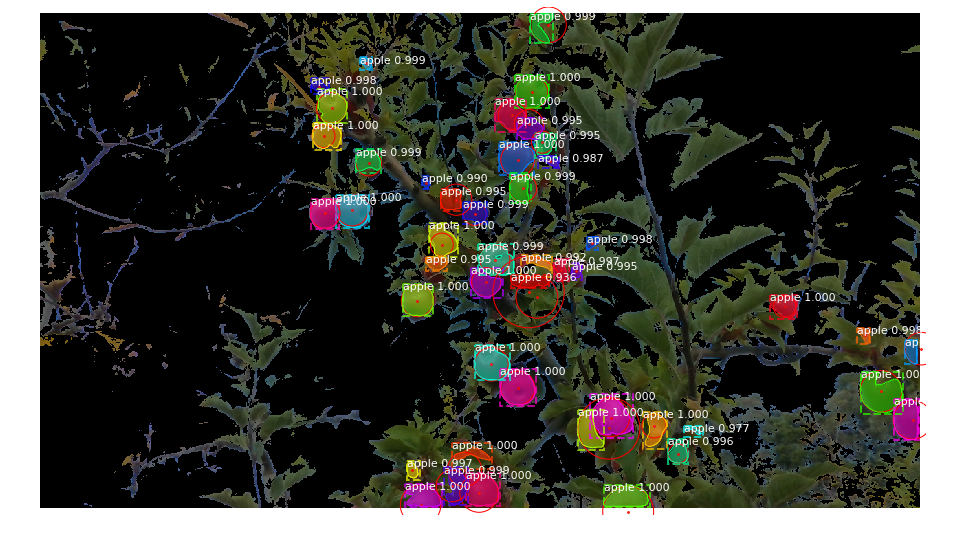

In [14]:
# Load a random image from the images folder
#file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

image = skimage.io.imread(os.path.join(IMAGE_DIR, "color_20190518T071146-Copy1-test.png"))
# Run detection
logging.debug('start detect')
results = model.detect([image], verbose=0)
logging.debug('end detect')

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])